In [1]:
%matplotlib inline

import logging
import os
import sys
import time
from datetime import datetime
from pathlib import Path
from typing import List, Optional
import SimpleITK as sitk

import glob
import ants
import matplotlib.pyplot as plt
import numpy as np
from ants import iMath, resample_image_to_target
import argparse

from aind_ccf_reg.preprocess import perc_normalization
from aind_ccf_reg.configs import PathLike
from aind_ccf_reg.plots import plot_reg, plot_antsimgs, plot_reg_before_after


## apply inverse transform, deform RT to the exaSPIM template space 

In [2]:


""" constant variables for class and color definition"""
CLASS_COLOR_MAP = {
    # 0: [256, 256, 256],
    # 64: [255, 0, 0],
    # 170: [0, 255, 0],
    # 35: [0, 0, 255],
    # 262: [255, 0, 255],
    # 100: [0, 255, 255],
    # 908: [255, 55, 0],
    # 91: [0, 128, 128],
    0.0: [256, 256, 256],
    1.0: [255, 0, 255],
    2.0: [255, 0, 255],

}
 
def overlay_labels(ants_mask, template, figpath, title, half_size=[1159, 689, 787], vmin=0, vmax=500):
    """" overlay labels and templates """
    ants_mask = ants_mask.numpy()
    # half_size = np.array(ants_mask.shape) // 2
    fig, ax = plt.subplots(1, 3, figsize=(10, 6))
    # half_size = [ i //2 for i in half_size ]
    print(half_size)
    mask2d_map = [ 
          ants_mask[half_size[0], :, :], 
          ants_mask[:, half_size[1], :], 
          ants_mask[:,:, half_size[2],]]

    img2d_map = [ 
          template[half_size[0], :, :], 
          template[:, half_size[1], :], 
          template[:,:, half_size[2],]]

    for loc in [0, 1, 2]:   
        label_map = mask2d_map[loc]
        image_map = img2d_map[loc]
        
        label_map_3d = np.ndarray(shape=(label_map.shape[0], label_map.shape[1], 3), dtype=int)

        for i in range(0, label_map.shape[0]):
            for j in range(0, label_map.shape[1]):
                label_map_3d[i][j] = CLASS_COLOR_MAP[ label_map[i][j] ]  
                
        ax[loc].imshow( image_map, cmap='gray', vmin=vmin, vmax=vmax )
        ax[loc].imshow( (label_map_3d/label_map_3d.max() * 255).astype(np.uint8) , alpha=0.5)
   
    fig.suptitle(title, y=0.9)
    if figpath:
        plt.savefig(f"{figpath}.jpg", bbox_inches = 'tight', pad_inches = 0.1)

print("")

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_antsimgs(ants_img, figpath, title="", half_size=[1159, 689, 787], vmin=0, vmax=1.5):
    """
    Plot ANTs image

    Parameters
    ------------
    ants_img: ANTsImage
    figpath: PathLike
        Path where the plot is going to be saved
    title: str
        Figure title
    vmin: float
        Set the color limits of the current image.
    vmax: float
        Set the color limits of the current image.
    """

    if figpath:
        ants_img = ants_img.numpy()
        half_size = np.array(ants_img.shape) // 2
        # half_size = [ i //2 for i in half_size ]
        print(half_size)
        fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(
            ants_img[half_size[0], :, :], cmap="gray", vmin=vmin, vmax=vmax
        )
        ax[1].imshow(
            ants_img[:, half_size[1], :], cmap="gray", vmin=vmin, vmax=vmax
        )
        im = ax[2].imshow(
            ants_img[
                :,
                :,
                half_size[2],
            ],
            cmap="gray",
            vmin=vmin,
            vmax=vmax,
        )
        fig.suptitle(title, y=0.9)
        plt.colorbar(
            im, ax=ax.ravel().tolist(), fraction=0.1, pad=0.025, shrink=0.7
        )
        plt.savefig(figpath, bbox_inches="tight", pad_inches=0.1)


### load RT annotation was annotated in deformed exaSPIM template in CCF space

In [4]:
out_prefix = "../results"
# RT = ants.image_read('/data/RT_annotation/RT.nrrd')
# RT = ants.image_read("/data/inferior_cerebellar_peduncle_annotation/inferior_cerebellar_peduncle.nrrd")
label = ants.image_read("/data/Py_annotation/Py.nrrd")

# label = label/2.0
print(label)


ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]



[974, 720, 540]
[660 400 570]


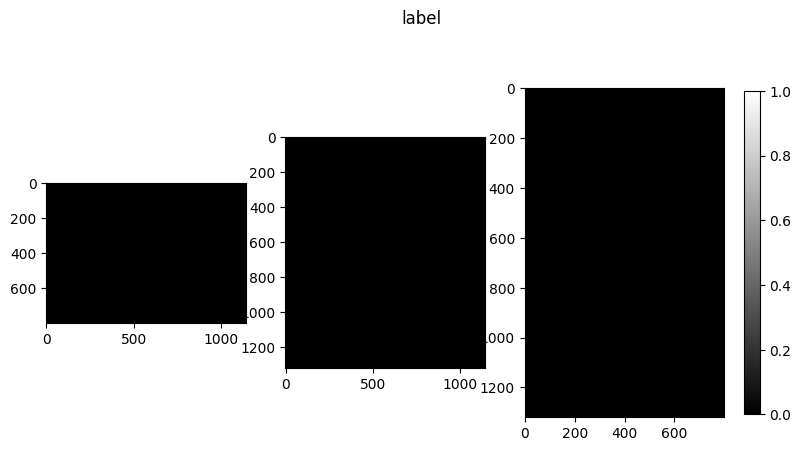

In [5]:
half_size = [1159, 689, 787]
half_size = [974, 720, 540]

# half_size = [ i //3 for i in label.shape ]
print(half_size)

plot_antsimgs(label, 
              f"{out_prefix}/label",
              half_size =half_size, 
              title=f"label", 
              vmin=0, vmax=1)

In [6]:
np.unique(label.numpy())

array([0., 1.], dtype=float32)

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[660 400 570]
ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[660 400 570]


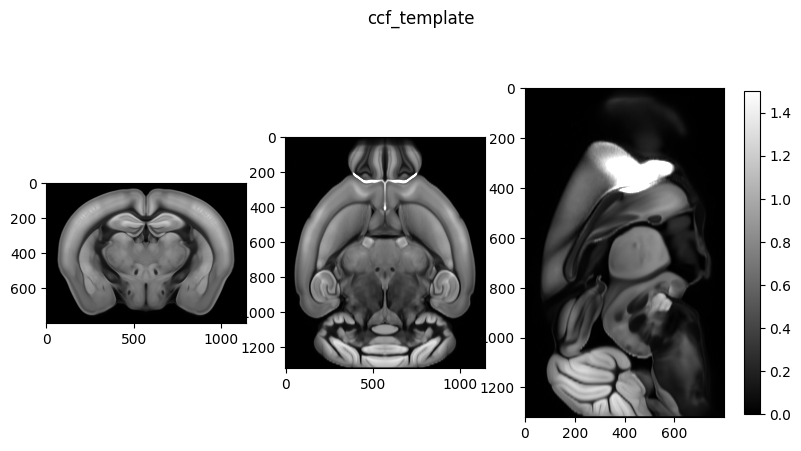

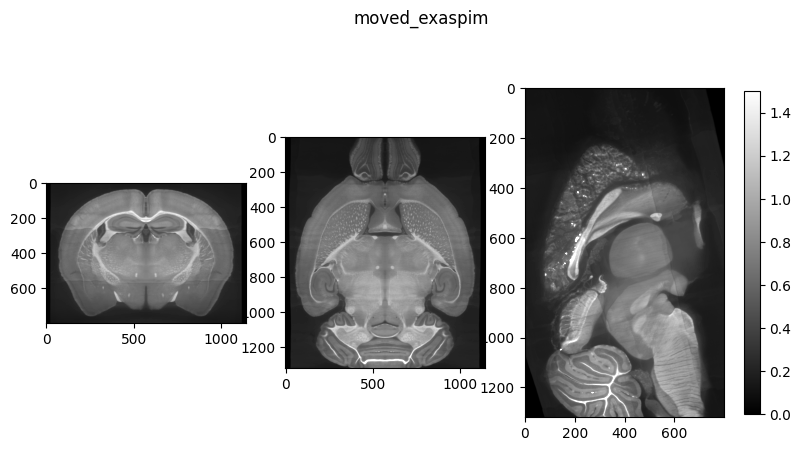

In [7]:
out_prefix = "../results"
ccf = ants.image_read('../data/allen_mouse_ccf/average_template/average_template_10.nii.gz')
ccf = perc_normalization(ccf)
print(ccf)
plot_antsimgs(ccf, 
              f"{out_prefix}/ccf_template",
              title=f"ccf_template", 
              half_size =half_size, 
              vmin=0, vmax=1.5)


moved_exaspim = ants.image_read('/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/moved_exaspim_to_ccf_10um.nii.gz')
print(moved_exaspim)
plot_antsimgs(moved_exaspim, 
              f"{out_prefix}/moved_exaspim",
              title=f"moved_exaspim", 
              half_size =half_size, 
              vmin=0, vmax=1.5)


[660 400 570]
[660 400 570]


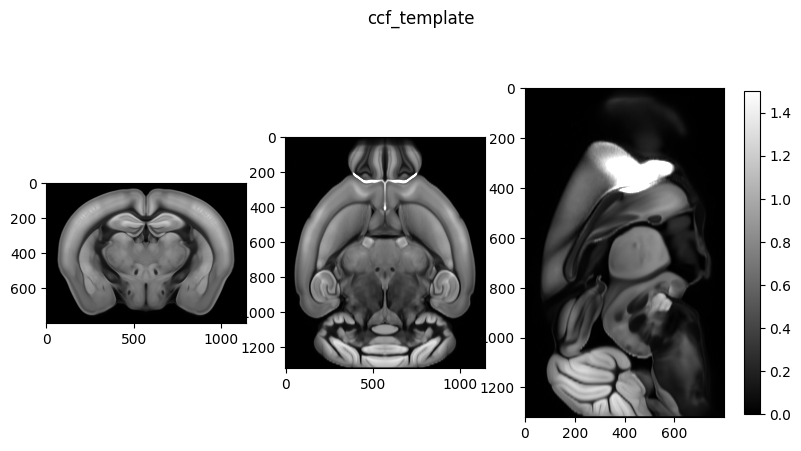

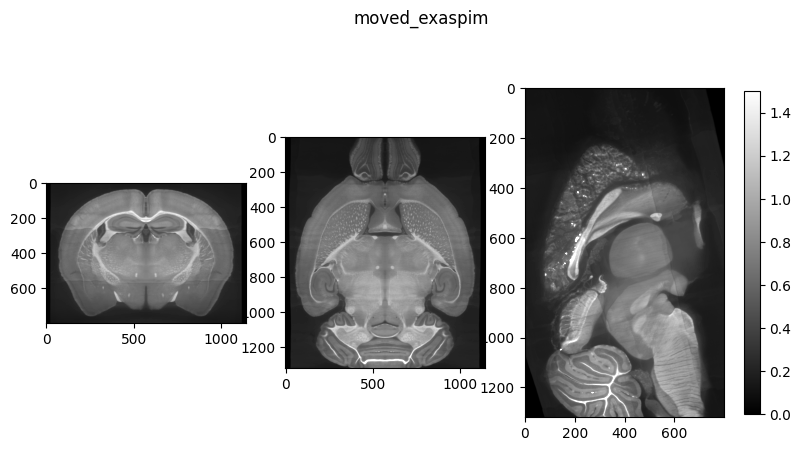

In [8]:
plot_antsimgs(ccf, 
              f"{out_prefix}/ccf_template",
              title=f"ccf_template", 
              half_size =half_size, 
              vmin=0, vmax=1.5)
plot_antsimgs(moved_exaspim, 
              f"{out_prefix}/moved_exaspim",
              title=f"moved_exaspim", 
              half_size =half_size, 
              vmin=0, vmax=1.5)



In [9]:
moved_exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]


[974, 720, 540]
[974, 720, 540]


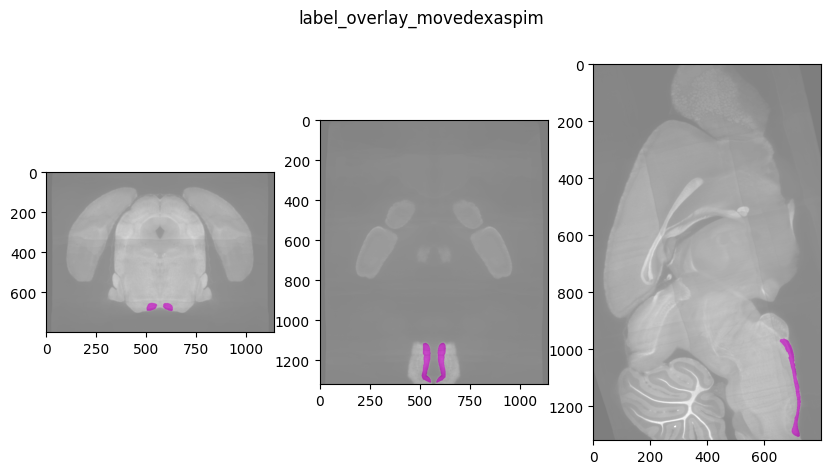

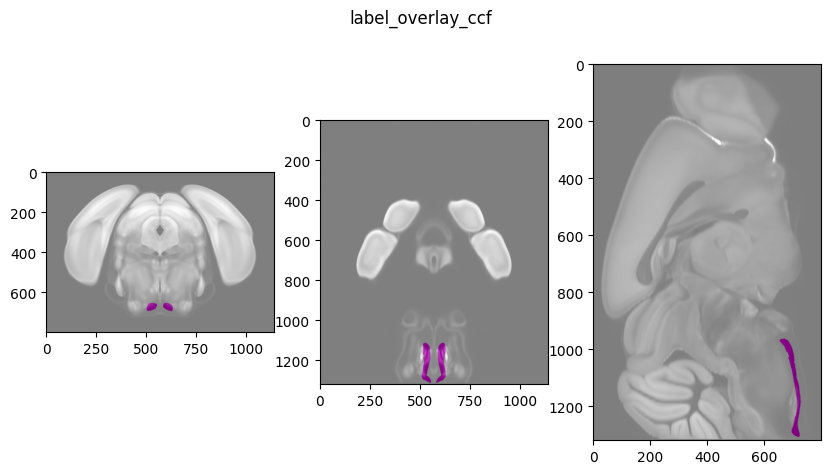

In [10]:
print("")
# overlay label labels on CCF
overlay_labels(label, moved_exaspim, "label_overlay_movedexaspim", title="label_overlay_movedexaspim", half_size =half_size, vmin=0, vmax=2.0)
# overlay label labels on CCF
overlay_labels(label, ccf, "label_overlay_ccf", title="label_overlay_ccf", half_size =half_size, vmin=0, vmax=None)


In [11]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

## apply inverse transform to deform label to exaSPIM template space


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (10.0, 10.0, 10.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

[810 550 720]


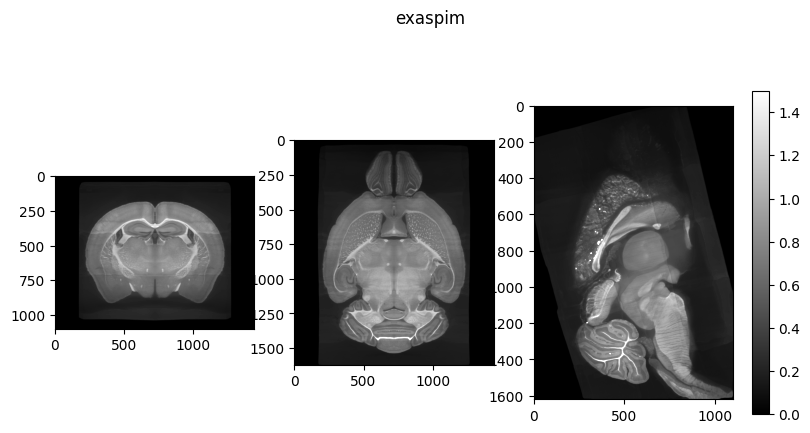

In [12]:
file = "/data/exaspim_template_7subjects_nomask_10um_round6_template_only/fixed_median.nii.gz"
exaspim = ants.image_read(file)
print(exaspim)
plot_antsimgs(exaspim, 
              f"{out_prefix}/exaspim",
              title=f"exaspim", 
              vmin=0, vmax=1.5)


[810 550 720]


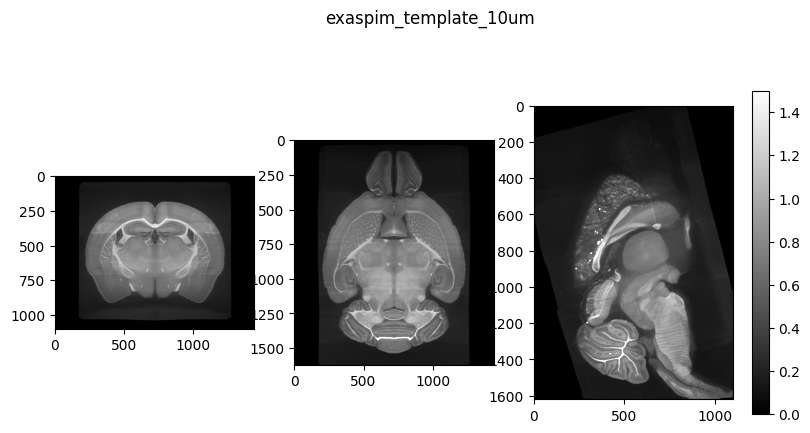

In [13]:

exaspim.set_spacing( ccf.spacing )
exaspim.set_origin( ccf.origin )
exaspim.set_direction( ccf.direction )

plot_antsimgs(exaspim, 
              f"../results/exaspim_template_10um",
              title=f"exaspim_template_10um", 
              vmin=0, vmax=1.5)


In [14]:
exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [15]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [16]:
moved_exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [17]:

ccf_to_exaspim_transform_path = [
    "/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/0GenericAffine.mat",
    "/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/1InverseWarp.nii.gz",
]
print(ccf_to_exaspim_transform_path)

inverse_moved_exaspim = ants.apply_transforms(
    fixed=exaspim,
    moving=moved_exaspim,
    transformlist=ccf_to_exaspim_transform_path,
)


['/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/0GenericAffine.mat', '/data/reg_exaspim_template_to_ccf_withGradMap_10um_v1.0/1InverseWarp.nii.gz']


In [18]:
diff = exaspim - inverse_moved_exaspim


[810 550 720]
[810 550 720]
[810 550 720]


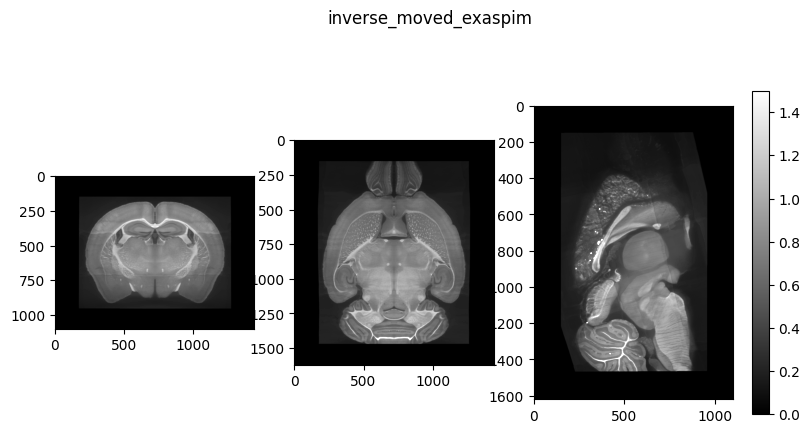

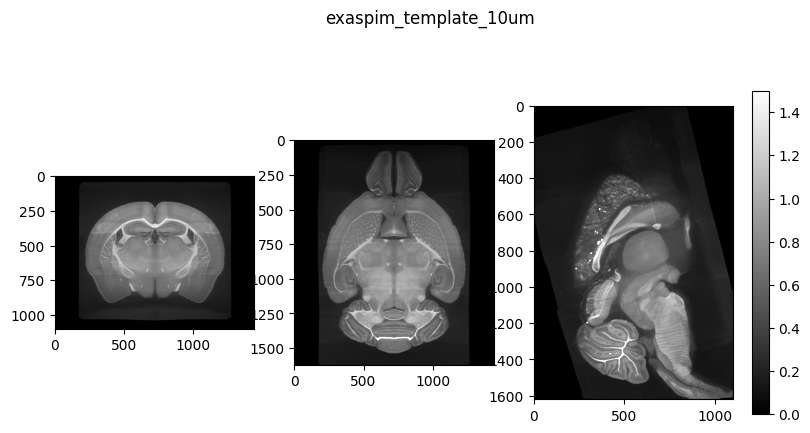

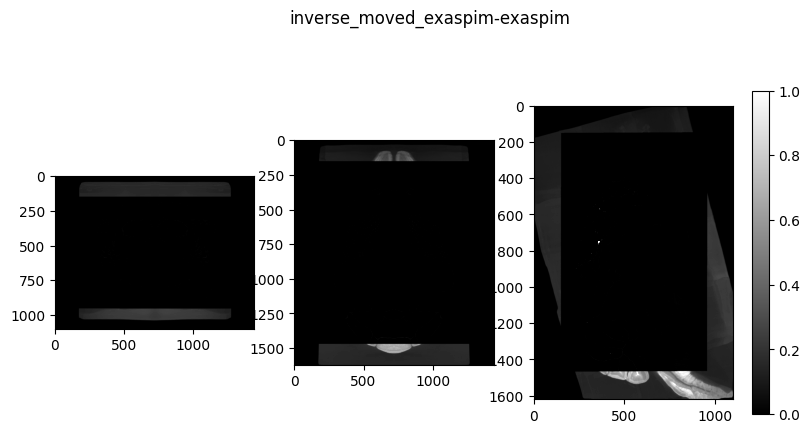

In [19]:
print("")
plot_antsimgs(inverse_moved_exaspim, 
              f"../results/inverse_moved_exaspim",
              title=f"inverse_moved_exaspim", 
              vmin=0, vmax=1.5)
plot_antsimgs(exaspim, 
              f"../results/exaspim_template_10um",
              title=f"exaspim_template_10um", 
              vmin=0, vmax=1.5)

plot_antsimgs(diff, 
              f"../results/inverse_moved_exaspim-exaspim",
              title=f"inverse_moved_exaspim-exaspim", 
              vmin=0, vmax=1)


## inverse label to exaSPIM space 

In [20]:
label

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

In [21]:
label_exaspim = ants.apply_transforms(
    fixed=exaspim,
    moving=label,
    transformlist=ccf_to_exaspim_transform_path,
    interpolator="nearestNeighbor",
)

In [22]:
exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [23]:
label_exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

In [24]:
half_size

[974, 720, 540]

In [25]:
loc1 = [ int(a/b*c) for a, b, c in zip(half_size, (1320, 800, 1140), (1620, 1100, 1440))  ] 
loc1 = [1400, 872, 753]

[810 550 720]


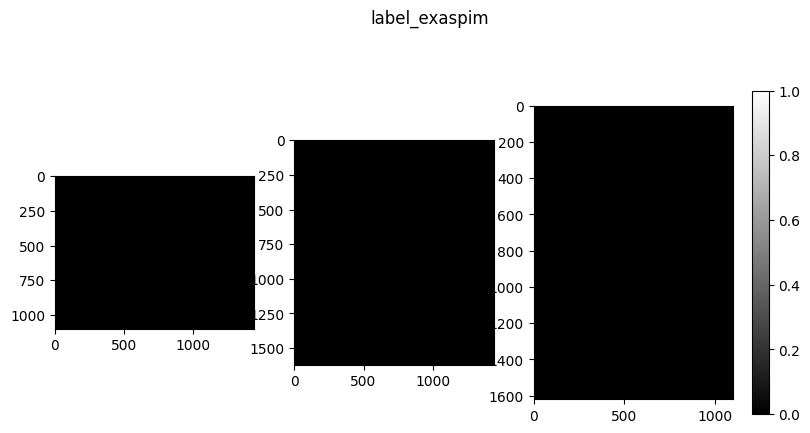

In [26]:
plot_antsimgs(label_exaspim, 
              f"../results/label_exaspim",
              title=f"label_exaspim", 
              half_size=loc1,
              vmin=0, vmax=1)


In [27]:
label_exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]


[1400, 872, 753]


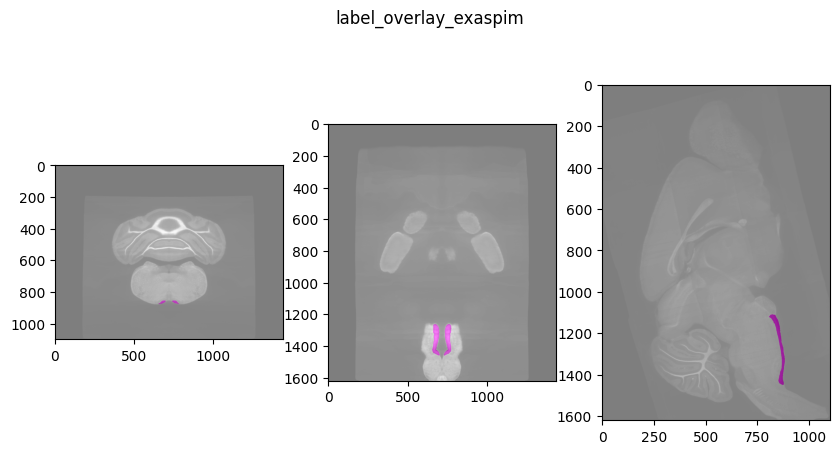

In [28]:
print("")
# overlay label labels on CCF
overlay_labels(label_exaspim, exaspim, "label_overlay_exaspim", title="label_overlay_exaspim",  half_size=loc1,vmin=0, vmax=None)

In [29]:
np.unique(label_exaspim.numpy())

array([0., 1.], dtype=float32)

In [60]:
# ants.image_write(label_exaspim, "/data/exaspim_anno_RT_10um.nii.gz")
ants.image_write(label_exaspim, "/data/exaspim_anno_pyramid_10um.nii.gz")



### resample label to 25um

In [30]:
label_exaspim

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1620, 1100, 1440)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

In [31]:
resample_spacing = (0.025, 0.025, 0.025)
label_exaspim_25 = ants.resample_image(label_exaspim, resample_spacing, interp_type=1)
print(label_exaspim_25)


ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]



In [32]:
loc = [ int(a/b*c) for a, b, c in zip([1159, 689, 787], (1320, 800, 1140), [648, 440, 576])  ] 
loc = [576, 348, 272]

[324 220 288]


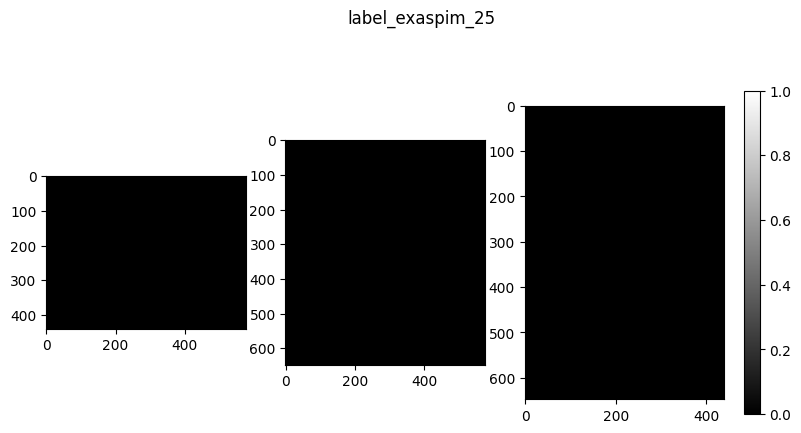

In [33]:

plot_antsimgs(label_exaspim_25, 
              f"../results/label_exaspim_25",
              title=f"label_exaspim_25", 
              half_size=loc,
              vmin=0, vmax=1)


In [68]:
# ants.image_write(label_exaspim_25, "/data/exaspim_anno_RT_25um.nii.gz")
# ants.image_write(label_exaspim_25, "/data/exaspim_anno_inferior_cerebellar_peduncle_25um.nii.gz")
ants.image_write(label_exaspim_25, "/data/exaspim_anno_pyramid_25um.nii.gz")


In [34]:
exaspim_25 = ants.image_read("/data/exaspim_template_7sujects_nomask_25um_round6.nii.gz") # 25um
ccf_25 = ants.image_read('../data/allen_mouse_ccf/average_template/average_template_25.nii.gz')

print(exaspim_25)
print(ccf_25)

exaspim_25.set_spacing( ccf_25.spacing )
exaspim_25.set_origin( ccf_25.origin )
exaspim_25.set_direction( ccf_25.direction )
    

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]




[576, 348, 272]


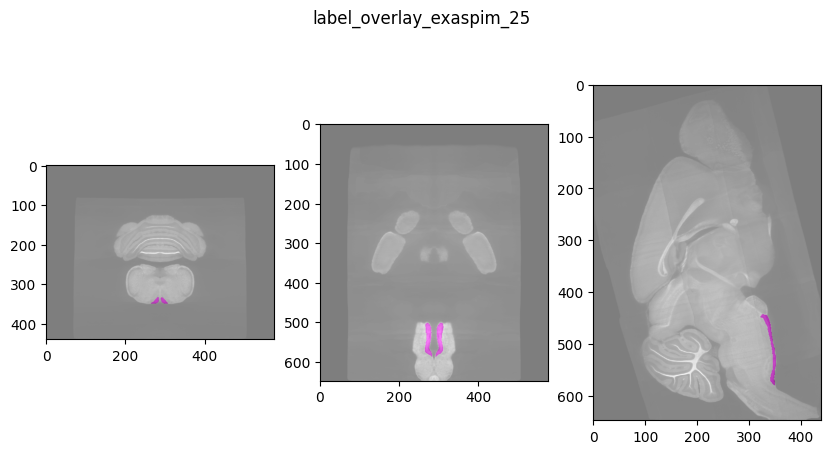

In [35]:
print("")
# overlay RT labels on CCF
overlay_labels(label_exaspim_25, exaspim_25, "label_overlay_exaspim_25", title="label_overlay_exaspim_25", half_size=loc, vmin=0, vmax=None)

### Make two sides

In [36]:
# tp = label_exaspim_25.numpy()
# print(tp.shape)
# tp = tp[:, :, ::-1]
# print(tp.shape)
# label_exaspim_25_lr = ants.from_numpy(tp)
# label_exaspim_25_lr.set_spacing( label_exaspim_25.spacing )
# label_exaspim_25_lr.set_origin( label_exaspim_25.origin )
# label_exaspim_25_lr.set_direction( label_exaspim_25.direction )


# print("")
# overlay_labels(label_exaspim_25, exaspim_25, "label_overlay_exaspim_25", title="label_overlay_exaspim_25", half_size=loc, vmin=0, vmax=None)

# overlay_labels(label_exaspim_25_lr, exaspim_25, "label_overlay_exaspim_25", title="label_overlay_exaspim_25", half_size=loc, vmin=0, vmax=None)

# overlay_labels(label_exaspim_25_lr + label_exaspim_25, exaspim_25, "label_overlay_exaspim_25", title="label_overlay_exaspim_25", half_size=loc, vmin=0, vmax=None)

# print(label_exaspim_25_lr)
# print(label_exaspim_25)
# label_exaspim_25_2sides = label_exaspim_25_lr + label_exaspim_25
# ants.image_write(label_exaspim_25_2sides, "/data/exaspim_anno_inferior_cerebellar_peduncle_25um_twosides.nii.gz")


## load GT --> label annotation in CCF

In [37]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[660 400 570]


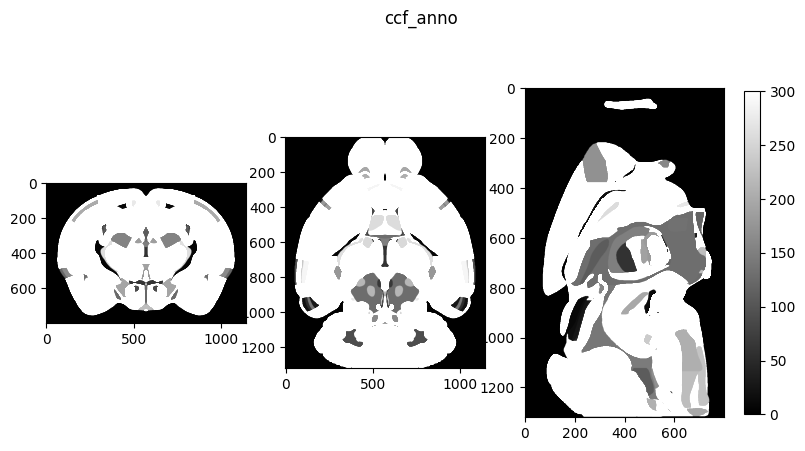

In [38]:
anno = ants.image_read("/data/allen_mouse_ccf/annotation/ccf_2017/annotation_10.nii.gz")
print(anno)
plot_antsimgs(anno, 
              f"{out_prefix}/ccf_anno",
              title=f"ccf_anno", 
              vmin=0, vmax=300)


### extract label annotation with label 190
id	name	acronym	hemisphere_id	parent_structure_id	graph_order	structure_id_path	color_hex_triplet
17	262	Reticular nucleus of the thalamus	label	3	856	703	/997/8/343/1129/549/856/262/	FF909F

In [39]:
anno_arr = anno.numpy()
# mask = (anno_arr == 262) # RT
# mask = (anno_arr == 1123) # inferior cerebellar peduncle
mask = (anno_arr == 190) # py

masked_arr = mask.astype("float32")

label_gt = ants.from_numpy(masked_arr)

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[660 400 570]


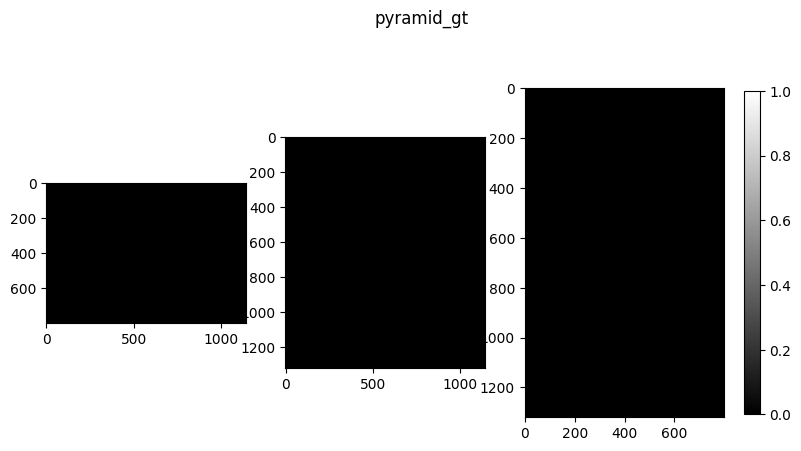

In [40]:
label_gt.set_spacing( ccf.spacing )
label_gt.set_origin( ccf.origin )
label_gt.set_direction( ccf.direction )
print(label_gt)
plot_antsimgs(label_gt, 
              f"../results/pyramid_gt",
              title=f"pyramid_gt", 
              vmin=0, vmax=1)


[1159, 689, 787]


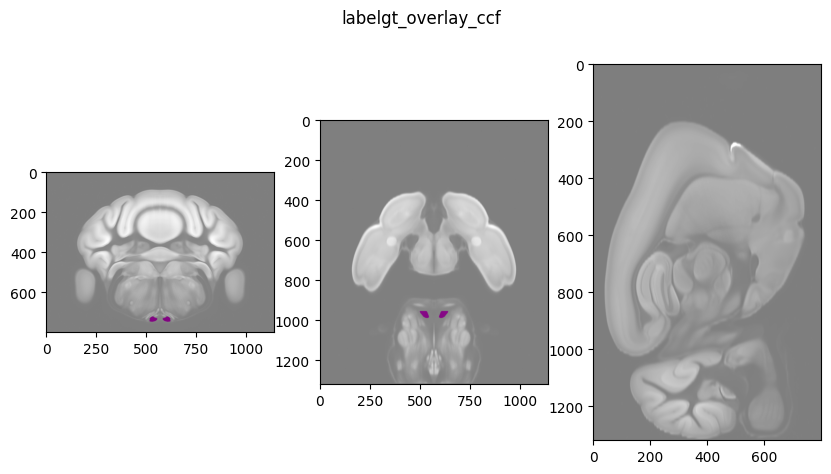

In [41]:
print("")
# overlay label labels on CCF
overlay_labels(label_gt, ccf, "labelgt_overlay_ccf", title="labelgt_overlay_ccf", vmin=0, vmax=None)

In [42]:
label_gt

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [43]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1320, 800, 1140)
	 Spacing    : (0.01, 0.01, 0.01)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [79]:
ants.image_write(label_gt, "/data/ccf_anno_pyramid_10um.nii.gz")

### load label_gt 25 um

In [44]:
ccf_25

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[463, 275, 314]
[463, 275, 314]
[264 160 228]
ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]


[264 160 228]


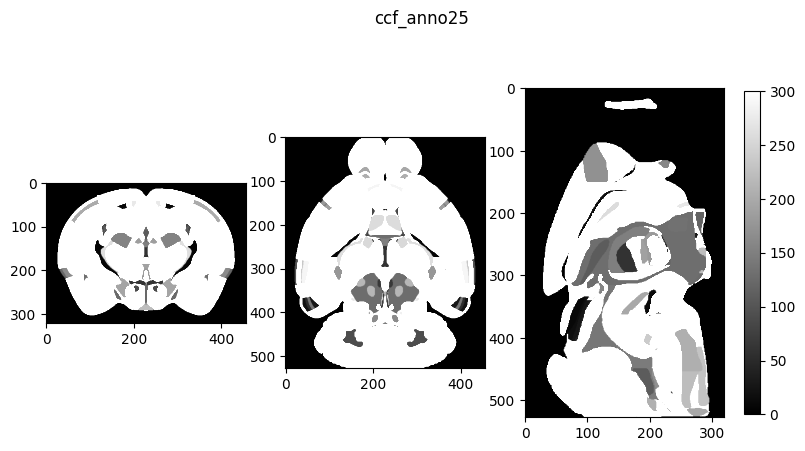

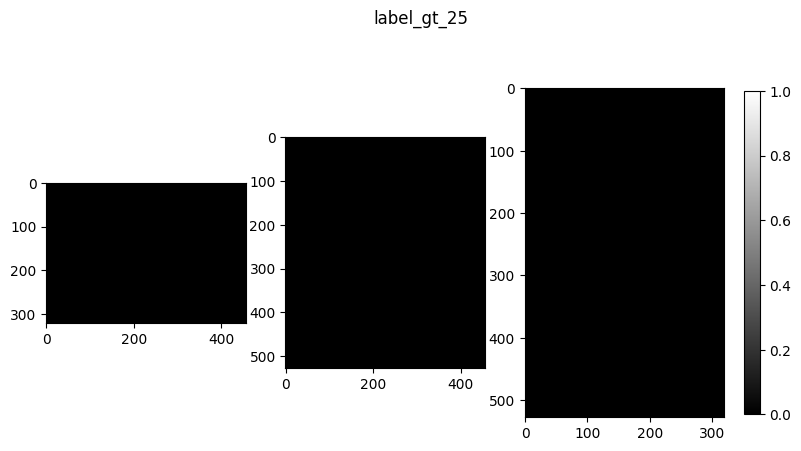

In [45]:
anno = ants.image_read("/data/allen_mouse_ccf/annotation/ccf_2017/annotation_25.nii.gz")
print(anno)
out_prefix = "/results/"
loc2 = [ int(float(a/b*c)) for a, b, c in zip([1159, 689, 787], (1320, 800, 1140), (528, 320, 456))  ] 
print(loc2)
print(loc2)


plot_antsimgs(anno, 
              f"{out_prefix}/ccf_anno25",
              title=f"ccf_anno25", 
              half_size=loc2,
              vmin=0, vmax=300)
anno_arr = anno.numpy()
# mask = (anno_arr == 262)
# mask = (anno_arr == 1123) # inferior cerebellar peduncle
mask = (anno_arr == 190) # py


masked_arr = mask.astype("float32")

label_gt = ants.from_numpy(masked_arr)

label_gt.set_spacing( ccf_25.spacing )
label_gt.set_origin( ccf_25.origin )
label_gt.set_direction( ccf_25.direction )
print(label_gt)

print("")

plot_antsimgs(label_gt, 
              f"../results/pyramid_gt_25",
              title=f"label_gt_25", 
              half_size=loc2,
              vmin=0, vmax=1)



[463, 275, 314]


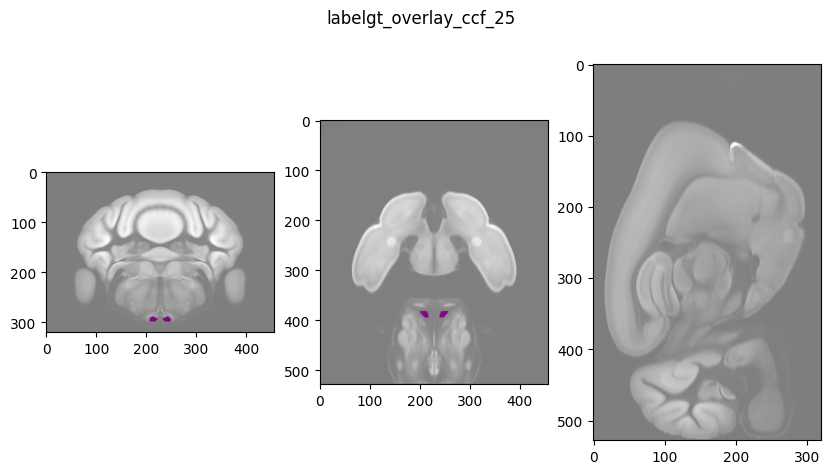

In [46]:

# overlay label labels on CCF
overlay_labels(label_gt, ccf_25, "labelgt_overlay_ccf_25", title="labelgt_overlay_ccf_25", half_size=loc2, vmin=0, vmax=None)

In [47]:
label_gt

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [85]:
ants.image_write(label_gt, "/data/ccf_anno_pyramid_25um.nii.gz")


In [48]:
np.unique(label_gt.numpy())

array([0., 1.], dtype=float32)

In [49]:
# resample_spacing = (0.025, 0.025, 0.025)
# label_gt_25 = ants.resample_image(label_gt,resample_spacing, interp_type=1)
# print(label_gt_25)

# plot_antsimgs(label_gt_25, 
#               f"../results/label_gt_25",
#               title=f"RT_gt_25", 
#               vmin=0, vmax=1.5)


# start exaspim-to-ccf registration

In [50]:
exaspim = ants.image_read("/data/exaspim_template_7sujects_nomask_25um_round6.nii.gz") # 25um
ccf = ants.image_read('../data/allen_mouse_ccf/average_template/average_template_25.nii.gz')
ccf = perc_normalization(ccf)

print(exaspim)
print(ccf)


ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]



In [51]:
ICP_exaspim_25 = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_inferior_cerebellar_peduncle_25um_twosides.nii.gz")
py_exaspim_25 = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_pyramid_25um.nii.gz")
RT_exaspim_25 = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_RT_25um_twosides.nii.gz")
AV_exaspim_25 = ants.image_read("/data/RT_anno_for_reg/exaspim_anno_Arbor_Vitae_25um.nii.gz")
print("exaspim template labels unique values:", np.unique(ICP_exaspim_25.numpy()))
print("exaspim template labels unique values:", np.unique(RT_exaspim_25.numpy()))
print("exaspim template labels unique values:", np.unique(AV_exaspim_25.numpy()))
print("exaspim template labels unique values:", np.unique(py_exaspim_25.numpy()))


ICP_gt = ants.image_read("/data/RT_anno_for_reg/ccf_anno_inferior_cerebellar_peduncle_25um.nii.gz")
py_gt = ants.image_read("/data/RT_anno_for_reg/ccf_anno_pyramid_25um.nii.gz")
RT_gt = ants.image_read("/data/RT_anno_for_reg/ccf_anno_RT_25um.nii.gz")
AV_gt = ants.image_read("/data/RT_anno_for_reg/ccf_anno_Arbor_Vitae_25um.nii.gz")
print("ccf labels unique values:", np.unique(ICP_gt.numpy()))
print("ccf labels unique values:", np.unique(RT_gt.numpy()))
print("ccf labels unique values:", np.unique(AV_gt.numpy()))
print("ccf labels unique values:", np.unique(py_gt.numpy()))



exaspim template labels unique values: [0. 1.]
exaspim template labels unique values: [0. 1.]
exaspim template labels unique values: [0. 1.]
exaspim template labels unique values: [0. 1.]
ccf labels unique values: [0. 1.]
ccf labels unique values: [0. 1.]
ccf labels unique values: [0. 1.]
ccf labels unique values: [0. 1.]


In [52]:
exaspim_label = ICP_exaspim_25+AV_exaspim_25 + RT_exaspim_25 + py_exaspim_25
ccf_label = ICP_gt+ AV_gt+RT_gt + py_gt

In [53]:
ccf_label

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [54]:
exaspim_label

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]

In [55]:
print("exaspim template labels unique values:", np.unique(exaspim_label.numpy()))
print("ccf labels unique values:", np.unique(ccf_label.numpy()))


exaspim template labels unique values: [0. 1. 2.]
ccf labels unique values: [0. 1.]


In [56]:

labels_exaspim_arr = exaspim_label.numpy()
labels_exaspim_arr[labels_exaspim_arr > 0] = 1
exaspim_label = ants.from_numpy(
        labels_exaspim_arr.astype("float32"), 
        spacing=exaspim_label.spacing,
        origin=exaspim_label.origin, 
        direction=exaspim_label.direction
       )
print(exaspim_label)

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [ 0.  0. -1.  1.  0.  0.  0. -1.  0.]




[463, 260, 340]


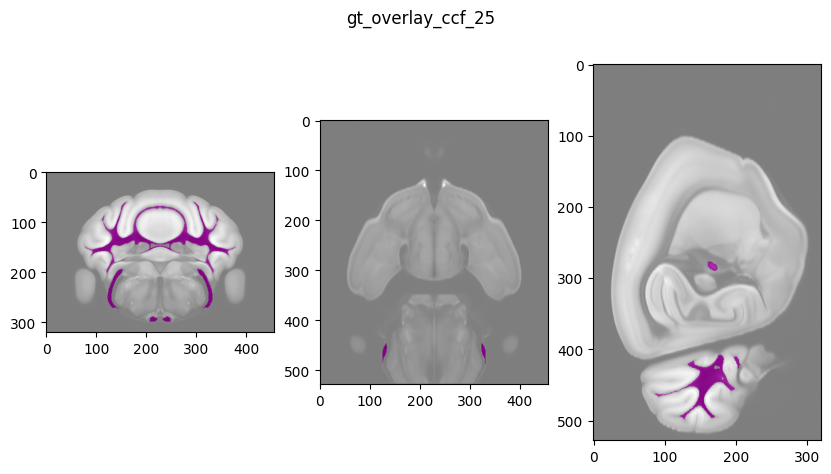

In [57]:
print("")
overlay_labels(ccf_label, ccf, "gt_overlay_ccf_25", title="gt_overlay_ccf_25", half_size=[463, 260, 340],vmin=0, vmax=None)

In [58]:
ccf_label

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [59]:
loc3 = [ int(float(a/b*c)) for a, b, c in zip([463, 260, 340], (528, 320, 456), (648, 440, 576))  ] 
loc3

[568, 357, 429]


[568, 357, 429]


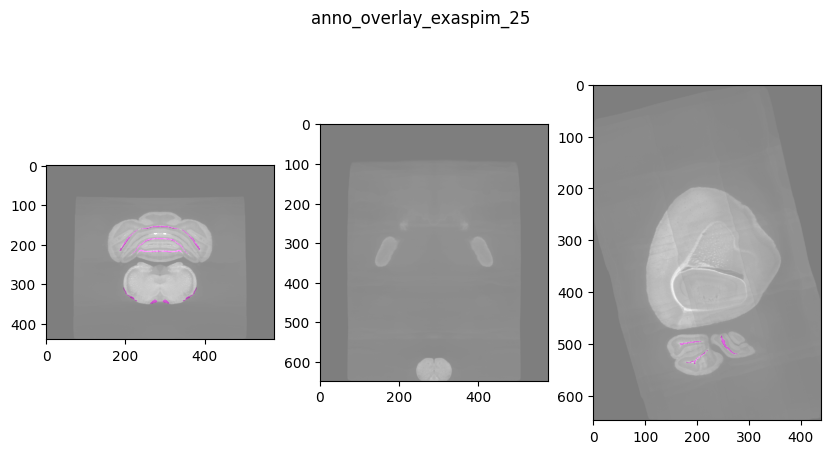

In [60]:
print("")
overlay_labels(exaspim_label, exaspim, "anno_overlay_exaspim_25", title="anno_overlay_exaspim_25", half_size=loc3,vmin=0, vmax=1.5)

## set up registration parameters

In [61]:
import os

syn_sampling=2
weight_gradient = 0.5
# syn_reg_iterations = (1000, 500, 200, 10)
syn_reg_iterations = (500, 200, 100, 10)
syn_reg_iterations_str = "_".join( str(i) for i in syn_reg_iterations)
        
out_prefix = f"../results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_py_synsample{syn_sampling}_iter{syn_reg_iterations_str}_wG{weight_gradient}/"
if not os.path.exists(out_prefix):
    os.mkdir(out_prefix)

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[264 160 228]
ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (648, 440, 576)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[324 220 288]


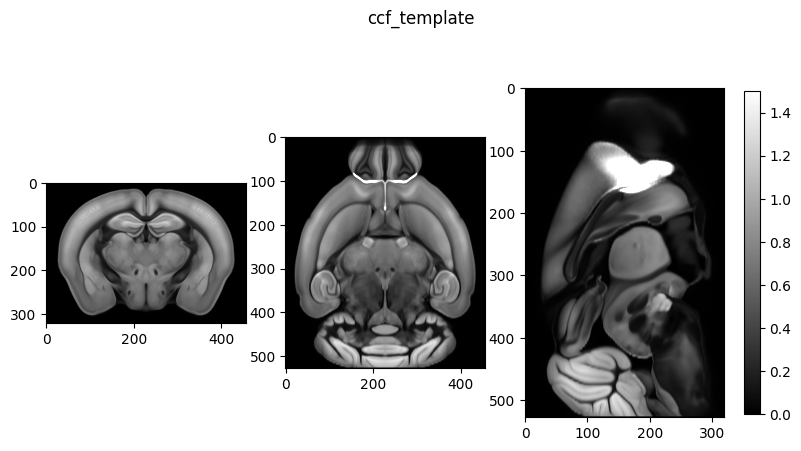

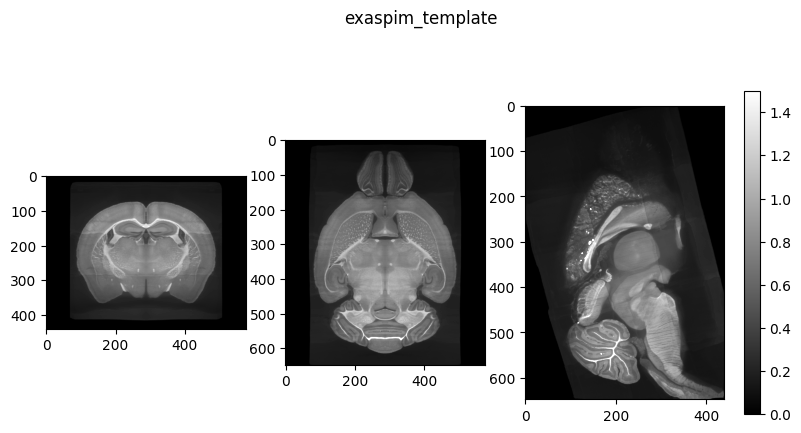

In [62]:
print(ccf)
plot_antsimgs(ccf, 
              f"{out_prefix}/ccf_template",
              title=f"ccf_template", 
              vmin=0, vmax=1.5)

print(exaspim)
plot_antsimgs(exaspim, 
              f"{out_prefix}/exaspim_template",
              title=f"exaspim_template", 
              vmin=0, vmax=1.5)

In [63]:
# # old
# # exaspim template generated with 7 subjects
# exaspim = ants.image_read("../data/exaSPIM_template_25um_to_smartspim_to_ccf/exaspim_template_7sujects_nomask_25um_round6_swapped.nii.gz", reorient='ASL')
# # exaspim = ants.image_read("../data/exaSPIM_template_25um_to_smartspim_to_ccf/exaspim_template_7sujects_nomask_25um_round6_swapped.nii.gz")

# print(exaspim)
# plot_antsimgs(exaspim, 
#               f"{out_prefix}/exaspim_template",
#               # f"/results/exaspim_template",
#               title=f"exaspim_template", 
#               vmin=0, vmax=1.5)

In [64]:
# # old
# # exaspim = ants.image_read("../data/exaspim_template_8sujects_nomask_25um_round2/update_round_2_average_template/fixed.nii.gz")
# # exaspim = ants.image_read("../data/exaspim_template_8sujects_nomask_10um_round5_only_template/fixed_median.nii.gz")
# # exaspim = ants.image_read("../data/exaspim_template_7subjects_nomask_10um_round6_template_only/fixed_median.nii.gz")
# exaspim = ants.image_read("../data/exaSPIM_template_25um_to_smartspim_to_ccf/exaspim_template_7sujects_nomask_25um_round6_swapped.nii.gz")
# print(exaspim)
# plot_antsimgs(exaspim, 
#               f"{out_prefix}/exaspim_template",
#               title=f"exaspim_template", 
#               vmin=0, vmax=1.5)

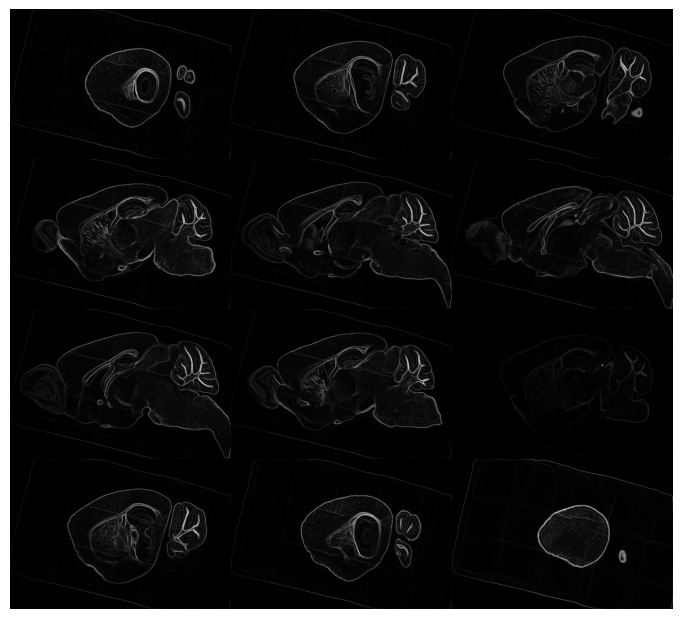

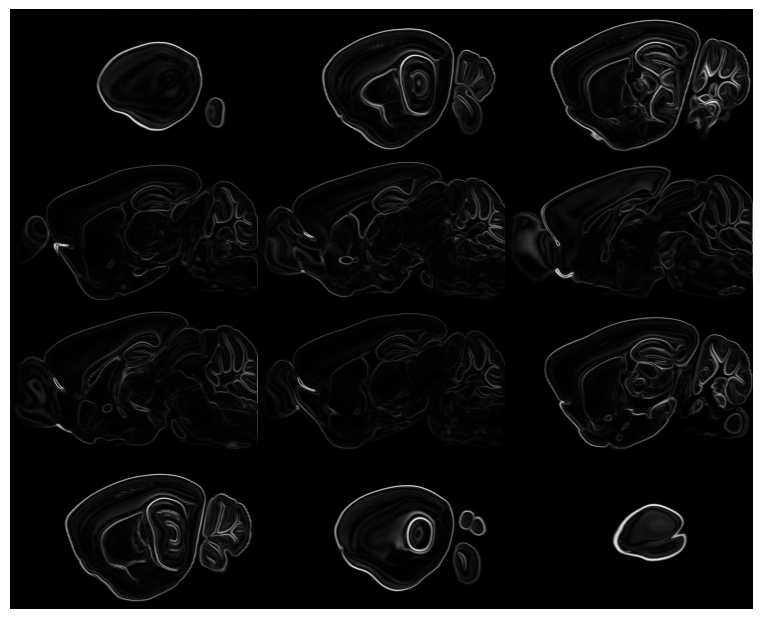

In [65]:
print("")
template = exaspim
T= sitk.GetImageFromArray(template.view())
F = sitk.GradientMagnitudeImageFilter()
G = F.Execute(T)
template_gradient = sitk.GetArrayViewFromImage(G)
template_gradient = ants.from_numpy(template_gradient)
template_gradient = ants.copy_image_info(template,template_gradient)
template_gradient.plot()

C= sitk.GetImageFromArray(ccf.view())
F = sitk.GradientMagnitudeImageFilter()
G = F.Execute(C)
ccf_gradient = sitk.GetArrayViewFromImage(G)
ccf_gradient = ants.from_numpy(ccf_gradient)
ccf_gradient = ants.copy_image_info(ccf,ccf_gradient)
ccf_gradient.plot()

## rigid + affine + syn

In [66]:
def ants_register_syn(fixed = None, 
                      moving = None,
                      mask = None,
                      moving_mask  = None, # Applied on in Syn Step
                      template_gradient = None,
                      ccf_gradient = None,
                      mask_all_stages = False,
                      syn_save_prefix="",
                      syn_metric = "mattes",
                      syn_sampling = 2,
                      syn_reg_iterations = (500, 200, 10),
                      weight_gradient = 0.5, 
                      exaspim_label= None,
                     ccf_label= None):
    """
    Perform SyN registration using ANTs, initialized with a rigid and affine transformation.

    This function aligns a moving image to a fixed image using the Symmetric Normalization (SyN) 
    method from ANTs (Advanced Normalization Tools). The process begins with a two-stage initialization: 
    first computing a rigid transformation, followed by an affine transformation. The SyN registration 
    is then performed, initialized with the results of the affine transformation.

    Parameters
    ----------
    fixed : ants.ANTsImage
        The target image for registration.
    moving : ants.ANTsImage
        The source image to be aligned to the fixed image.
    mask : ants.ANTsImage, optional
        Mask for the fixed image. Used in all stages if mask_all_stages is True.
    moving_mask : ants.ANTsImage, optional
        Mask for the moving image, applied only in the SyN step.
    mask_all_stages : bool, optional
        If True, apply the fixed image mask in all registration stages.
    syn_save_prefix : str, optional
        Prefix for saving the output files from the SyN registration.
    syn_metric : str, optional
        Metric for SyN registration (e.g., "CC" for Cross-Correlation).
    syn_sampling : int, optional
        Sampling strategy for SyN metric computation.
    syn_reg_iterations : tuple of int, optional
        The number of iterations at each level during SyN registration.

    Returns
    -------
    dict
        A dictionary containing the results of the registration, including forward and inverse 
        transformations, warp fields, and other details.

    Examples
    --------
    >>> fixed = ants.image_read('path/to/fixed_image.nii.gz')
    >>> moving = ants.image_read('path/to/moving_image.nii.gz')
    >>> syn_results = ants_register_syn(fixed, moving, syn_save_prefix='output_prefix_')
    
    Docstring modified by ChatGPT.
    """
    
    print("computing rigid")

    tx_rigid = ants.registration(
        fixed=fixed,
        moving=moving,
        mask = mask,
        moving_mask = moving_mask,
        mask_all_stages = mask_all_stages,
        type_of_transform="Rigid",
        aff_smoothing_sigmas=[3, 2, 1, 0],
    )
    
    print("computing affine")
    tx_affine = ants.registration(
        fixed=fixed,
        moving=moving,
        mask = mask,
        moving_mask = moving_mask,
        mask_all_stages = mask_all_stages,
        initial_transform=tx_rigid["fwdtransforms"][0],
        type_of_transform="Affine",
        aff_smoothing_sigmas=[3, 2, 1, 0],
    )
    print("computing syn")
    tx_syn = ants.registration(
        # fixed=ccf_gradient,
        # moving=template_gradient,
        fixed=fixed,
        moving=moving,
        mask = mask,
        moving_mask = moving_mask,
        mask_all_stages = mask_all_stages,
        initial_transform=tx_affine["fwdtransforms"][0],
        outprefix=str(syn_save_prefix),
        type_of_transform="SyNOnly",
        syn_metric=syn_metric,
        grad_step=0.2,
        syn_sampling=syn_sampling,
        reg_iterations = syn_reg_iterations,
        multivariate_extras =[
                            # ['MeanSquares',ccf_gradient, template_gradient, weight_gradient, 8],
                             ['mattes',ccf_gradient, template_gradient, weight_gradient, 8], # enforace that small structuers should be aprox. equal
                             ['MeanSquares',ccf_label,exaspim_label,1,0]] # enforace that large structuers should be aprox. equal
                          #['mattes',template,ccf_template,.5,32]] # enforace that boarders should be aprox the same.
        )
    print("registration compltete")
    return tx_syn

In [67]:
syn_reg_iterations

(500, 200, 100, 10)

In [68]:
weight_gradient

0.5

In [69]:
reg = ants_register_syn(fixed=ccf, 
                        moving=exaspim,
                        template_gradient = template_gradient,
                        ccf_gradient = ccf_gradient,
                        syn_metric='mattes',
                        syn_sampling=syn_sampling,
                        syn_reg_iterations = syn_reg_iterations,
                        weight_gradient= weight_gradient,
                        syn_save_prefix=out_prefix,
                        exaspim_label=exaspim_label,
                        ccf_label= ccf_label
                       )


computing rigid
computing affine
computing syn
registration compltete


In [70]:
ants_reg = reg["warpedmovout"]

In [71]:
transform_path = [
    f"{out_prefix}/1Warp.nii.gz",
    f"{out_prefix}/0GenericAffine.mat"
]

In [72]:
start_time = datetime.now()
ants_reg = ants.apply_transforms(
    fixed=ccf,
    moving=exaspim,
    transformlist=transform_path,
)
end_time = datetime.now()



In [73]:
ants.image_write(ants_reg, f"{out_prefix}/moved_exaspim_to_ccf_25um.nii.gz")

In [74]:
print(
    f"Register to ccf, execution time: {end_time - start_time} s -- image {ants_reg}"
)

Register to ccf, execution time: 0:00:13.160518 s -- image ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]



In [75]:
ccf

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

In [76]:
ants_reg

ANTsImage (ASL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (528, 320, 456)
	 Spacing    : (0.025, 0.025, 0.025)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-0.  0. -1.  1. -0.  0.  0. -1.  0.]

[264 160 228]


2025-09-15 01:26 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6480682].
2025-09-15 01:26 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.2051282].
2025-09-15 01:26 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..23.464813].


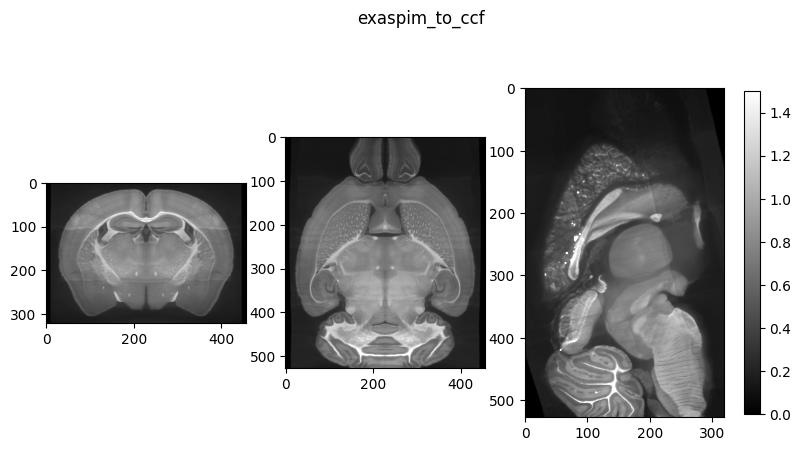

In [77]:

dataset_id = "exaspim_to_ccf"
figpath = f"{out_prefix}{dataset_id}"
plot_antsimgs(ants_reg, figpath, title=f"{dataset_id}", vmin=0, vmax=1.5)

for loc in [0, 1, 2]:
    title = f"reg_{dataset_id}_{loc}"
    figpath = f"{out_prefix}/reg_{dataset_id}_{loc}"
    plot_reg(exaspim, 
             ccf,
             ants_reg, 
             figpath, title, loc=loc, vmin=0, vmax=1.5)

# for loc in [0, 1, 2]:
#     figpath = f"{out_prefix}/reg_{dataset_id}_{loc}_before_after"
#     title = f"reg_{dataset_id}_{loc}"

#     plot_reg_before_after(
#              exaspim, 
#              ccf,
#              ants_reg, 
#              figpath, title, loc=loc, vmin=0, vmax=1.5)



In [78]:
fwd_transforms = reg['fwdtransforms']
print(f'Rigid complete, saved as {fwd_transforms}')


Rigid complete, saved as ['../results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_py_synsample2_iter500_200_100_10_wG0.5/1Warp.nii.gz', '../results/exaspim_7subj_to_ccf_img_withGrad_withRT_AV_ICP_py_synsample2_iter500_200_100_10_wG0.5/0GenericAffine.mat']
